In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the model
model = Sequential()

# First convolutional layer
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Fourth convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Fifth convolutional layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output for the fully connected layers
model.add(Flatten())

# Output layer
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation parameters
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
)

# Load training data
train_generator = train_datagen.flow_from_directory('DownsampledDataset2',
                                                    class_mode='categorical',
                                                    target_size=(224, 224),
                                                    batch_size=50)
val_generator = train_datagen.flow_from_directory('PreprocessedDataset/val',
                                                  class_mode='categorical',
                                                  target_size=(224, 224),
                                                  batch_size=50)

# Train the model
model.fit(train_generator, epochs=10, validation_data=val_generator)


Found 1500 images belonging to 3 classes.
Found 826 images belonging to 3 classes.


NameError: name 'model' is not defined

Found 1580 images belonging to 3 classes.
1580/1580 [==============================] - 13s 8ms/step
there were 1044 errors in 1580 tests for an accuracy of  33.92


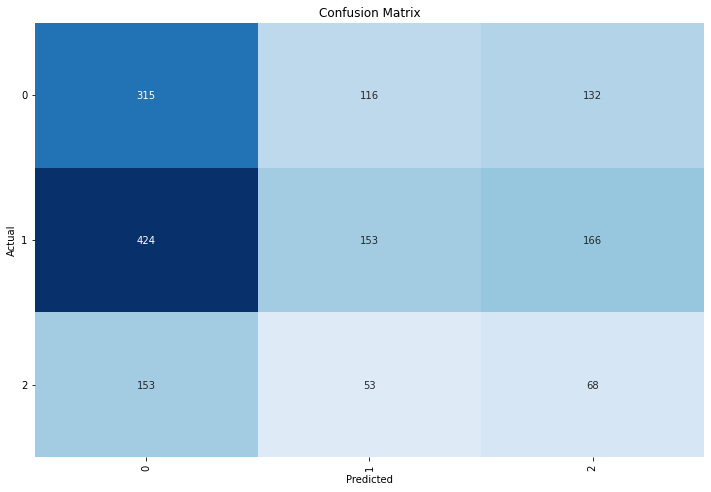

Classification Report:
----------------------
               precision    recall  f1-score   support

           0     0.3531    0.5595    0.4330       563
           1     0.4752    0.2059    0.2873       743
           2     0.1858    0.2482    0.2125       274

    accuracy                         0.3392      1580
   macro avg     0.3380    0.3379    0.3109      1580
weighted avg     0.3815    0.3392    0.3263      1580



In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]            
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
test_gen = train_datagen.flow_from_directory('PreprocessedDataset/test',
                                                  class_mode='categorical',
                                                  target_size=(224, 224),
                                                  batch_size=1)
errors, tests=predictor(test_gen, len(test_gen))

In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

# Create sequential model
model = Sequential()

# Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.add(base_model)

# Normalization layer
model.add(BatchNormalization())

# Global average pooling layer
model.add(GlobalAveragePooling2D())

# Regularization layer
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dropout(0.3))
# Classifier
model.add(Dense(3, activation='softmax'))

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              )

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=40,
    validation_data=val_generator,
    validation_steps=len(val_generator),
)

Epoch 1/40
30/30 [==============================] - 26s 671ms/step - loss: 10.4697 - accuracy: 0.5067 - val_loss: 11.8324 - val_accuracy: 0.1610
Epoch 2/40
11/30 [==========>...................] - ETA: 10s - loss: 5.5247 - accuracy: 0.6109

KeyboardInterrupt: 

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load VGG19 model with imagenet weights
vgg19 = VGG19(weights="imagenet", include_top=False)

# Take output from one of the earlier layers
x = vgg19.layers[-3].output

# Add additional layers similar to the ones in your Xception model
x = Conv2D(filters=1024, kernel_size=3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(filters=256, kernel_size=3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(filters=64, kernel_size=3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

# Assuming n_class is defined earlier in your code
n_class = 10  # You can change this according to your problem

x = Conv2D(filters=n_class, kernel_size=3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

# Global Average Pooling
GAP = GlobalAveragePooling2D()(x)

# Softmax activation for classification
pred = Activation("softmax")(GAP)

# Create model
vgg19_model = Model(inputs=vgg19.input, outputs=pred)
